In [1]:
import os 
import netCDF4
import pyproj
import re
import cv2

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pathlib import Path


In [2]:
dataset_path = "./2023/07/01/S_NWC_CMA_HIMA09_HIMA-N-NR_20230701T000000Z.nc"

dataset = netCDF4.Dataset(dataset_path)

cloud_mask = dataset.variables["cma"][:]

proj_string = dataset.gdal_projection  # The projection string from the dataset
gdal_xgeo_up_left = dataset.gdal_xgeo_up_left  # Upper-left X in projected coordinates
gdal_ygeo_up_left = dataset.gdal_ygeo_up_left  # Upper-left Y in projected coordinates
pixel_size_x = 2000  # Pixel size in the X-direction (derived from gdal_geotransform_table)
pixel_size_y = -2000  # Pixel size in the Y-direction (inverted Y-axis)

transformer_to_proj = pyproj.Transformer.from_crs("EPSG:4326", pyproj.CRS(proj_string), always_xy=True)

latitude = -35.3191  # latitude (MSO, Australia)
longitude = 149.0088 # longitude (MSO, Australia)

# Convert the latitude and longitude to projected coordinates (geostationary projection)
x_geo, y_geo = transformer_to_proj.transform(longitude, latitude)

# Convert projected coordinates to pixel coordinates
x_pixel = int((x_geo - gdal_xgeo_up_left) / pixel_size_x)
y_pixel = int((y_geo - gdal_ygeo_up_left) / pixel_size_y)

(-0.5, 5499.5, 5499.5, -0.5)

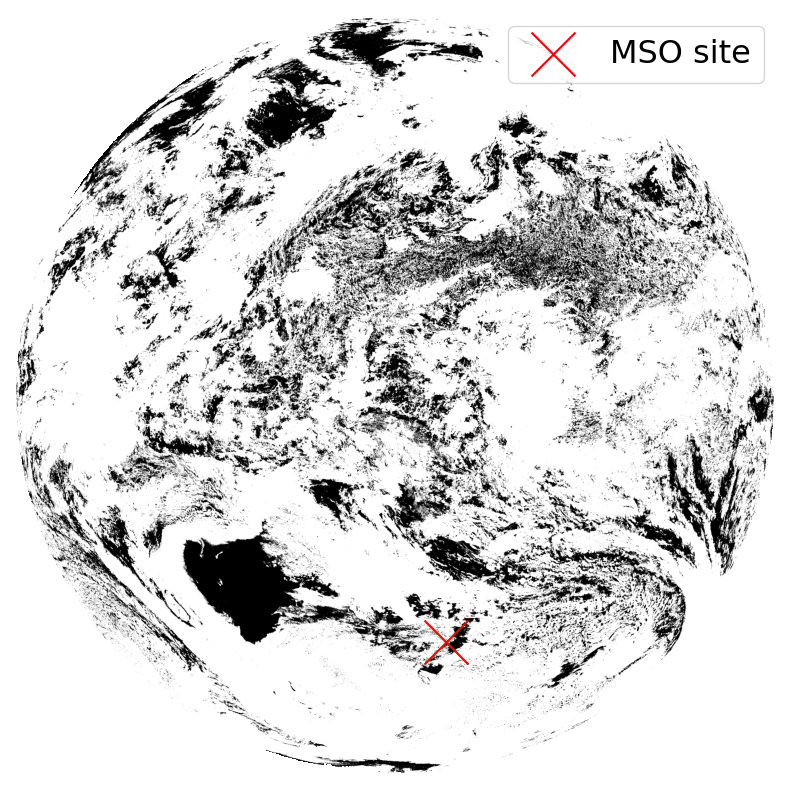

In [12]:

from matplotlib.legend_handler import HandlerPathCollection


plt.figure(figsize=(10, 10))
plt.imshow(cloud_mask, cmap='gray', origin='upper')

# Plot the point (x_pixel, y_pixel) on top of the image
scatter = plt.scatter(x_pixel, y_pixel, color='red', s=1000, marker='x', label='MSO site')


# Add legend to identify the point
plt.legend(handler_map={scatter: HandlerPathCollection(marker_pad=0.1)}, fontsize=23)
plt.axis('off')

In [6]:
mso_cloud = cloud_mask[y_pixel-4:y_pixel+4, x_pixel-4:x_pixel+4]

print(np.sum(mso_cloud.data == 1)/len(mso_cloud.data.flatten()))

0.578125


# Helper function

In [7]:
'''
Function used to extract the time, date, month and year from satlite image recorded

get the date from sat file name in form of year:month:day:hour:minute:second in UTC time 
'''
def time_sat(file_path : str):

    _, file_name = os.path.split(file_path)

    time_comp = file_name.split("_")[-1]

    date_sat = time_comp.split("T")[0]

    date_obj = datetime.strptime(date_sat, "%Y%m%d")


     # Use regular expressions to extract the substring between 'T' and 'Z'
    match = re.search(r'T(.*?)Z', time_comp)
    if match:
        dt = match.group(1)
    time_obj = datetime.strptime(dt, "%H%M%S") 

    final_time_obj = time_obj.replace(year=date_obj.year, month=date_obj.month, day=date_obj.day)

    return final_time_obj

In [8]:
# prediction helper function 

from urllib.parse import unquote

'''
get the date from prediction file name in form of year:month:day:hour:minute:second 
'''

def time_pre(file_path : str):

    dir_ls, file_name = os.path.split(file_path)

    date,time,others = file_name.split("_")

    date_ls = date.split("-")

    day = int(date_ls[0])
    month = int(date_ls[1])
    year = int(date_ls[2])
    
    # Decode the percent-encoded string
    decoded_time_str = unquote(time)

    time_obj = datetime.strptime(decoded_time_str, "%H:%M:%S")

    final_datetime_obj = time_obj.replace(year = int(year), month = int(month), day=int(day))
    
    return final_datetime_obj

In [9]:
'''
This will gives the moon up and down time according to the latitude, longitude and date
'''

import ephem
import pytz

def moon_time(lat, lon, date_str, hours_offset = 10):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elevation = 0

    observer.date = date_str
    
    # Create a moon object
    moon = ephem.Moon()

    # Calculate moonrise and moonset
    moonrise_time = observer.next_rising(moon)
    moonset_time = observer.next_setting(moon)

    moonrise_time_pre = observer.previous_rising(moon)
    moonset_time_pre = observer.previous_setting(moon)

    # Convert times to local time (UTC is returned by default)
    moonrise_utc = ephem.localtime(moonrise_time)
    moonset_utc = ephem.localtime(moonset_time)

    moonrise_utc_pre = ephem.localtime(moonrise_time_pre)
    moonset_utc_pre = ephem.localtime(moonset_time_pre)
    
    # Convert UTC times to the target timezone (UTC+10)
    moonrise_local_time = moonrise_utc + timedelta(hours=hours_offset)
    moonset_local_time = moonset_utc + timedelta(hours=hours_offset)

    moonrise_local_time_pre = moonrise_utc_pre + timedelta(hours=hours_offset)
    moonset_local_time_pre = moonset_utc_pre + timedelta(hours=hours_offset)
    
    return (moonrise_local_time, moonset_local_time), (moonrise_local_time_pre, moonset_local_time_pre)


In [10]:
name = "F:\\Cloud segment models\\Performance\\ACLNet\\2023_deadRemove\\pred/01-07-2023_00%3A05%3A02_moonglow.png"
name_sat = "F:\\Cloud segment models\\Validation of performance\\2023\\07\\01/S_NWC_CMA_HIMA09_HIMA-N-NR_20230701T000000Z.nc"
print(time_pre(name))
print(time_sat(name_sat))

moon_time(latitude,longitude,time_pre(name))

2023-07-01 00:05:02
2023-07-01 00:00:00


((datetime.datetime(2023, 7, 2, 0, 35, 25, 296117),
  datetime.datetime(2023, 7, 2, 15, 48, 56, 810099)),
 (datetime.datetime(2023, 6, 30, 23, 54, 9, 412207),
  datetime.datetime(2023, 7, 1, 14, 37, 19, 557648)))

# Evaluate with ACLNET

In [11]:
'''
generate the path list of prediction probability image and the corresponding path list of the satlite image 
'''

SATLITE_PATH = Path("F:\\Cloud segment models\\Validation of performance")
PREDICT_PATH = "F:\\Cloud segment models\\Performance\\ACLNet\\2023_deadRemove/prob"

predict_path = []
cor_sat_path = []

predict_path_with_moon = []
cor_sat_path_with_moon = []

predict_path_without_moon = []
cor_sat_path_without_moon = []

for _,_,f_ls in os.walk(PREDICT_PATH):

    for f in f_ls:
        
        # get the time for the prediciton 
        pre_time = time_pre(f)

        # find the closest time of the satlite image
        sat_time = pre_time - timedelta(hours=10)

        # path for the satlite image
        sat_path = SATLITE_PATH / str(sat_time.year) / str(sat_time.month).zfill(2) / str(sat_time.day).zfill(2)


        # get the list contains the time of satelite
        time_sat_ls = []
        f2_ls = os.listdir(sat_path)
        time_sat_ls = list(map(time_sat,f2_ls))

        closest_time = min(time_sat_ls, key=lambda t: abs(t - sat_time))
        closest_index = time_sat_ls.index(closest_time)

        # get the file name of the cloest time file name 
        sat_file_name = f2_ls[closest_index]


        # path for the prediciton and satlite image 
        pre_file_path = os.path.join(PREDICT_PATH,f)
        sat_file_path = os.path.join(sat_path,sat_file_name)
        
        predict_path.append(pre_file_path)
        cor_sat_path.append(sat_file_path)


        # check if the time is within moon up period 
        moon_period = moon_time(latitude,longitude,pre_time)


        if moon_period[0][0] <= pre_time <= moon_period[0][1] or moon_period[1][0] <= pre_time <= moon_period[1][1]:
            predict_path_with_moon.append(pre_file_path)
            cor_sat_path_with_moon.append(sat_file_path)
        else:
            predict_path_without_moon.append(pre_file_path)
            cor_sat_path_without_moon.append(sat_file_path)
        

In [12]:
print(len(predict_path),len(predict_path_with_moon),len(predict_path_without_moon))

8249 1548 6701


In [14]:
'''
This section will calculate the average prob for each list
'''

avg_prob_ls = []
avg_sat_ls = []

avg_prob_ls_with_moon = []
avg_sat_with_moon = []

avg_prob_ls_without_moon = []
avg_sat_without_moon = []

def get_avg_ls(pre_p_ls,sat_p_ls):
    avg_pre_ls = []
    avg_sat_ls = []
    for i in range(len(pre_p_ls)):
        # probability
        prob = cv2.imread(pre_p_ls[i]) / 255
    
        # cloud mask
        dataset_path = sat_p_ls[i]
        
        try:
            dataset = netCDF4.Dataset(dataset_path, 'r')
            cloud_mask = dataset.variables["cma"][:]
            print("done",i)
        except RuntimeError as e:
            print(dataset_path)
            print(f"RuntimeError: {e}")
        except KeyError as e:
            print(dataset_path)
            print(f"KeyError: {e} - The specified variable does not exist in the dataset.")
        except Exception as e:
            print(dataset_path)
            print(f"An error occurred: {e}")
        mso_cloud = cloud_mask[y_pixel-6:y_pixel+6, x_pixel-6:x_pixel+6]
    
        # avrage coverage of cloud at mso
        avg_mso_cloud = np.sum(mso_cloud.data == 1)/len(mso_cloud.data.flatten())
    
        avg_prob = np.mean(prob)
      
        avg_pre_ls.append(avg_prob)
        avg_sat_ls.append(avg_mso_cloud)

    return avg_pre_ls,avg_sat_ls

avg_prob_ls, avg_sat_ls = get_avg_ls(predict_path,cor_sat_path)
avg_prob_ls_with_moon, avg_sat_with_moon = get_avg_ls(predict_path_with_moon,cor_sat_path_with_moon)
avg_prob_ls_without_moon, avg_sat_without_moon = get_avg_ls(predict_path_without_moon,cor_sat_path_without_moon)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
done 100
done 101
done 102
done 103
done 104
done 105
done 106
done 107
done 108
done 109
done 110
done 111
done 112
done 113
done 114
done 115
done 116
done 117
done 118
done 119
done 120
done 121
done 122
don

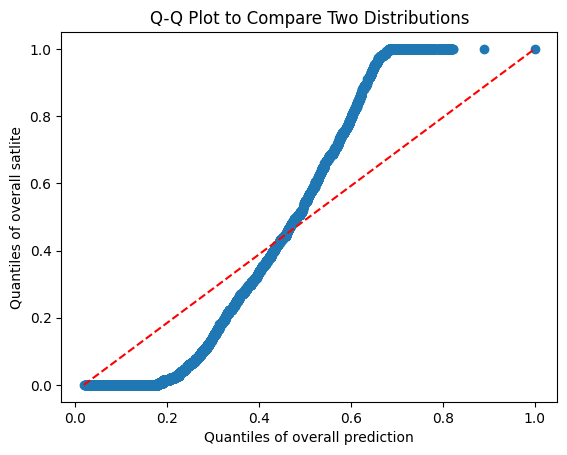

In [15]:
''' 
QQ plot to measure the similarity of distribution between avg probability and avg sat
'''
quantiles = np.linspace(0, 1, len(avg_prob_ls))
q1 = np.quantile(avg_prob_ls, quantiles)
q2 = np.quantile(avg_sat_ls, quantiles)

# Show the plot
plt.scatter(q1, q2)
plt.plot([min(q1), max(q1)], [min(q2), max(q2)], color='r', linestyle='--')  # Diagonal reference line
plt.xlabel('Quantiles of overall prediction')
plt.ylabel('Quantiles of overall satlite')
plt.title('Q-Q Plot to Compare Two Distributions')
plt.show()

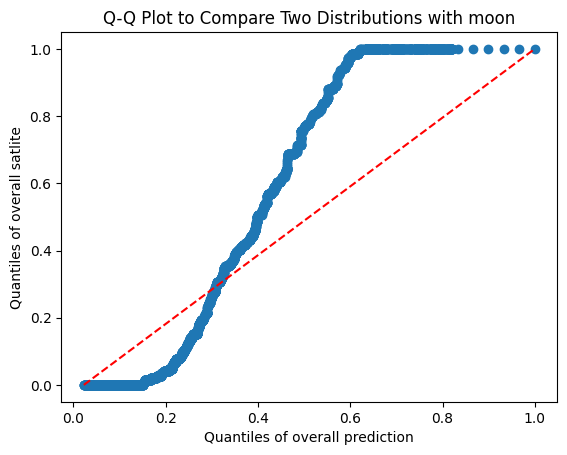

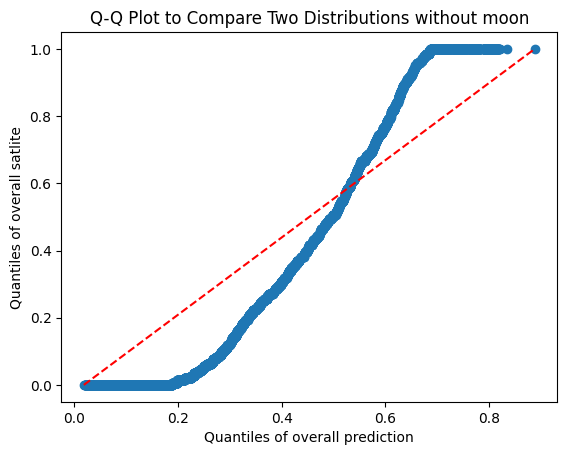

In [16]:
''' 
QQ plot to measure the similarity of distribution between avg probability and avg sat
'''
quantiles = np.linspace(0, 1, len(avg_prob_ls))
q1 = np.quantile(avg_prob_ls_with_moon, quantiles)
q2 = np.quantile(avg_sat_with_moon, quantiles)

# Show the plot
plt.scatter(q1, q2)
plt.plot([min(q1), max(q1)], [min(q2), max(q2)], color='r', linestyle='--')  # Diagonal reference line
plt.xlabel('Quantiles of overall prediction')
plt.ylabel('Quantiles of overall satlite')
plt.title('Q-Q Plot to Compare Two Distributions with moon')
plt.show()

''' 
QQ plot to measure the similarity of distribution between avg probability and avg sat
'''
quantiles = np.linspace(0, 1, len(avg_prob_ls))
q1 = np.quantile(avg_prob_ls_without_moon, quantiles)
q2 = np.quantile(avg_sat_without_moon, quantiles)

# Show the plot
plt.scatter(q1, q2)
plt.plot([min(q1), max(q1)], [min(q2), max(q2)], color='r', linestyle='--')  # Diagonal reference line
plt.xlabel('Quantiles of overall prediction')
plt.ylabel('Quantiles of overall satlite')
plt.title('Q-Q Plot to Compare Two Distributions without moon')
plt.show()

(array([3.480e+03, 1.324e+03, 1.005e+03, 5.890e+02, 4.940e+02, 5.560e+02,
        4.690e+02, 2.810e+02, 5.000e+01, 1.000e+00]),
 array([0.0183599 , 0.11650452, 0.21464915, 0.31279377, 0.4109384 ,
        0.50908302, 0.60722765, 0.70537228, 0.8035169 , 0.90166153,
        0.99980615]),
 <BarContainer object of 10 artists>)

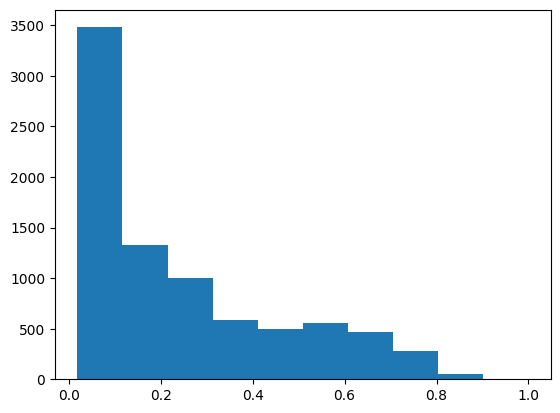

In [17]:
plt.hist(avg_prob_ls)

(array([5511.,  389.,  345.,  276.,  224.,  208.,  224.,  231.,  195.,
         646.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

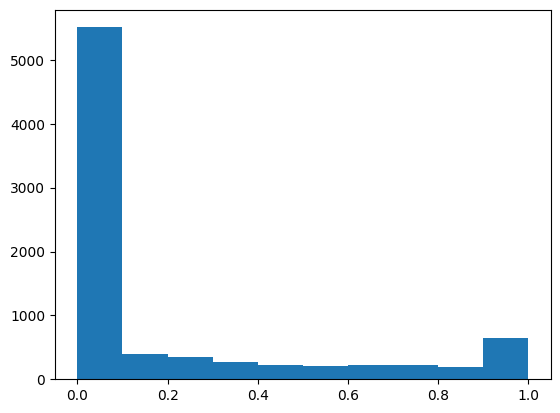

In [18]:
plt.hist(avg_sat_ls)

In [28]:
from scipy.stats import pearsonr

tau, p_value = pearsonr(avg_prob_ls, avg_sat_ls)

# Print the results
print(f"Pearson Correlation: {tau}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.3657061352399844
P-value: 1.865908942104355e-259


In [29]:
tau, p_value = pearsonr(avg_prob_ls_with_moon, avg_sat_with_moon)

# Print the results
print(f"Pearson Correlation: {tau}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.32498213756973315
P-value: 2.0994696934878783e-39


In [30]:
tau, p_value = pearsonr(avg_prob_ls_without_moon, avg_sat_without_moon)

# Print the results
print(f"Pearson Correlation: {tau}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.372134083647505
P-value: 3.826287533591666e-219
